In [1]:
# import the required packages
import numpy as np
import pandas as pd
from scipy.stats import zscore
from scipy.spatial.distance import cdist
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA 
from sklearn.cluster import AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, normalize 
from sklearn.metrics import silhouette_score 

from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model
from sklearn.model_selection import GridSearchCV

from sklearn.utils import resample
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder


## Build Clustering Models using Numerical Data

### 1.1 Data exploration and manipulation

#### Reading the dataset file

In [2]:
bank_data = pd.read_csv('Bank_Data.csv')
bank_data.head()

,Account Status,Duration in month,Credit History,Purpose,Credit amount,Savings account or bonds,Present employment since,Instalment rate in percentage of disposable income,Personal status and sex,Other debtors or guarantors,...,Property,Age in years,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,Foreign worker,Target
0,Salary assignments for at least 1 year,6,critical account/ other credits existing (not ...,radio/television,1169,Savings account,> 7 years,4,male : single,none,...,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes,1
1,Salary assignments for at least 2 year,48,existing credits paid back duly till now,radio/television,5951,Savings account,1 - 4 years,2,female : divorced/separated/married,none,...,real estate,22,none,own,1,skilled employee / official,1,None,yes,2
2,No Checking account,12,critical account/ other credits existing (not ...,education,2096,Savings account,4- 7 years,2,male : single,none,...,real estate,49,none,own,1,unskilled - resident,2,None,yes,1
3,Salary assignments for at least 1 year,42,existing credits paid back duly till now,furniture/equipment,7882,Savings account,4- 7 years,2,male : single,guarantor,...,building society savings agreement/ life insur...,45,none,for free,1,skilled employee / official,2,None,yes,1
4,Salary assignments for at least 1 year,24,delay in paying off in the past,car(new),4870,Savings account,1 - 4 years,3,male : single,none,...,unknown / no property,53,none,for free,2,skilled employee / official,2,None,yes,2


In [3]:
# All info
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   Account Status                                            1000 non-null   object
 1   Duration in month                                         1000 non-null   int64 
 2   Credit History                                            1000 non-null   object
 3   Purpose                                                   1000 non-null   object
 4   Credit amount                                             1000 non-null   int64 
 5   Savings account or bonds                                  1000 non-null   object
 6   Present employment since                                  1000 non-null   object
 7   Instalment rate in percentage of disposable income        1000 non-null   int64 
 8   Personal status and sex      

In [4]:
# Rename col names
bank_data = bank_data.rename(columns={'Account Status': 'acc_status', 'Duration in month': 'duration', 'Credit History': 'credit_hist',
                                     'Credit amount':'credit_amt', 'Savings account or bonds':'savings_or_bonds', 'Present employment since':'work_exp',
                                     'Personal status and sex':'relationship_status', 'Other debtors or guarantors':'other_debtors_guarantors', 'Age in years':'age',
                                     'Other installment plans':'installment_plans','Property':'property', 'Housing': 'housing', 'Number of existing credits at this bank' : 'no_of_existing_credit',
                                     'Job':'job', 'Telephone':'telephone', 'Foreign worker' : 'foreign_worker', 'Purpose':'purpose', 'Instalment rate in percentage of disposable income':'instalment_rate',
                                     'Number of people being liable to provide maintenance for':'liable_for_maintenance', 'Present residence since':'resident_since', 'Target':'risk'})

In [5]:
# Numeric Info
num_data = bank_data.select_dtypes(['int64', 'float64']).copy()
num_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   duration                1000 non-null   int64
 1   credit_amt              1000 non-null   int64
 2   instalment_rate         1000 non-null   int64
 3   resident_since          1000 non-null   int64
 4   age                     1000 non-null   int64
 5   no_of_existing_credit   1000 non-null   int64
 6   liable_for_maintenance  1000 non-null   int64
 7   risk                    1000 non-null   int64
dtypes: int64(8)
memory usage: 62.6 KB


In [6]:
num_data.head()

,duration,credit_amt,instalment_rate,resident_since,age,no_of_existing_credit,liable_for_maintenance,risk
0,6,1169,4,4,67,2,1,1
1,48,5951,2,2,22,1,1,2
2,12,2096,2,3,49,1,2,1
3,42,7882,2,4,45,1,2,1
4,24,4870,3,4,53,2,2,2


In [7]:
# Categorical Info
cat_data = bank_data.select_dtypes(['object']).copy()
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   acc_status                1000 non-null   object
 1   credit_hist               1000 non-null   object
 2   purpose                   1000 non-null   object
 3   savings_or_bonds          1000 non-null   object
 4   work_exp                  1000 non-null   object
 5   relationship_status       1000 non-null   object
 6   other_debtors_guarantors  1000 non-null   object
 7   property                  1000 non-null   object
 8   installment_plans         1000 non-null   object
 9   housing                   1000 non-null   object
 10  job                       1000 non-null   object
 11  telephone                 1000 non-null   object
 12  foreign_worker            1000 non-null   object
dtypes: object(13)
memory usage: 101.7+ KB


In [8]:
cat_data.head()

,acc_status,credit_hist,purpose,savings_or_bonds,work_exp,relationship_status,other_debtors_guarantors,property,installment_plans,housing,job,telephone,foreign_worker
0,Salary assignments for at least 1 year,critical account/ other credits existing (not ...,radio/television,Savings account,> 7 years,male : single,none,real estate,none,own,skilled employee / official,"yes, registered under the customers name",yes
1,Salary assignments for at least 2 year,existing credits paid back duly till now,radio/television,Savings account,1 - 4 years,female : divorced/separated/married,none,real estate,none,own,skilled employee / official,None,yes
2,No Checking account,critical account/ other credits existing (not ...,education,Savings account,4- 7 years,male : single,none,real estate,none,own,unskilled - resident,None,yes
3,Salary assignments for at least 1 year,existing credits paid back duly till now,furniture/equipment,Savings account,4- 7 years,male : single,guarantor,building society savings agreement/ life insur...,none,for free,skilled employee / official,None,yes
4,Salary assignments for at least 1 year,delay in paying off in the past,car(new),Savings account,1 - 4 years,male : single,none,unknown / no property,none,for free,skilled employee / official,None,yes


#### Data cleaning

In [9]:
cat_data.head()

,acc_status,credit_hist,purpose,savings_or_bonds,work_exp,relationship_status,other_debtors_guarantors,property,installment_plans,housing,job,telephone,foreign_worker
0,Salary assignments for at least 1 year,critical account/ other credits existing (not ...,radio/television,Savings account,> 7 years,male : single,none,real estate,none,own,skilled employee / official,"yes, registered under the customers name",yes
1,Salary assignments for at least 2 year,existing credits paid back duly till now,radio/television,Savings account,1 - 4 years,female : divorced/separated/married,none,real estate,none,own,skilled employee / official,None,yes
2,No Checking account,critical account/ other credits existing (not ...,education,Savings account,4- 7 years,male : single,none,real estate,none,own,unskilled - resident,None,yes
3,Salary assignments for at least 1 year,existing credits paid back duly till now,furniture/equipment,Savings account,4- 7 years,male : single,guarantor,building society savings agreement/ life insur...,none,for free,skilled employee / official,None,yes
4,Salary assignments for at least 1 year,delay in paying off in the past,car(new),Savings account,1 - 4 years,male : single,none,unknown / no property,none,for free,skilled employee / official,None,yes


In [10]:
# Get unique data
cat_data['relationship_status'].value_counts()

male : single                          548
female : divorced/separated/married    310
male : married/widowed                  92
male : divorced/separated               50
Name: relationship_status, dtype: int64

In [11]:
cat_data = cat_data.rename(columns={'relationship_status':'gender'})

gender = {'male : single' : 'Male', 'male : married/widowed' : 'Male', 'male : divorced/separated' : 'Male', 'female : divorced/separated/married' : 'Female'}
cat_data.replace(gender,inplace=True)
cat_data.head()

,acc_status,credit_hist,purpose,savings_or_bonds,work_exp,gender,other_debtors_guarantors,property,installment_plans,housing,job,telephone,foreign_worker
0,Salary assignments for at least 1 year,critical account/ other credits existing (not ...,radio/television,Savings account,> 7 years,Male,none,real estate,none,own,skilled employee / official,"yes, registered under the customers name",yes
1,Salary assignments for at least 2 year,existing credits paid back duly till now,radio/television,Savings account,1 - 4 years,Female,none,real estate,none,own,skilled employee / official,None,yes
2,No Checking account,critical account/ other credits existing (not ...,education,Savings account,4- 7 years,Male,none,real estate,none,own,unskilled - resident,None,yes
3,Salary assignments for at least 1 year,existing credits paid back duly till now,furniture/equipment,Savings account,4- 7 years,Male,guarantor,building society savings agreement/ life insur...,none,for free,skilled employee / official,None,yes
4,Salary assignments for at least 1 year,delay in paying off in the past,car(new),Savings account,1 - 4 years,Male,none,unknown / no property,none,for free,skilled employee / official,None,yes


In [12]:
# Find outliers
num_data.describe()

,duration,credit_amt,instalment_rate,resident_since,age,no_of_existing_credit,liable_for_maintenance,risk
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,1.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,2.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


C:\Users\shani\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\shani\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\shani\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


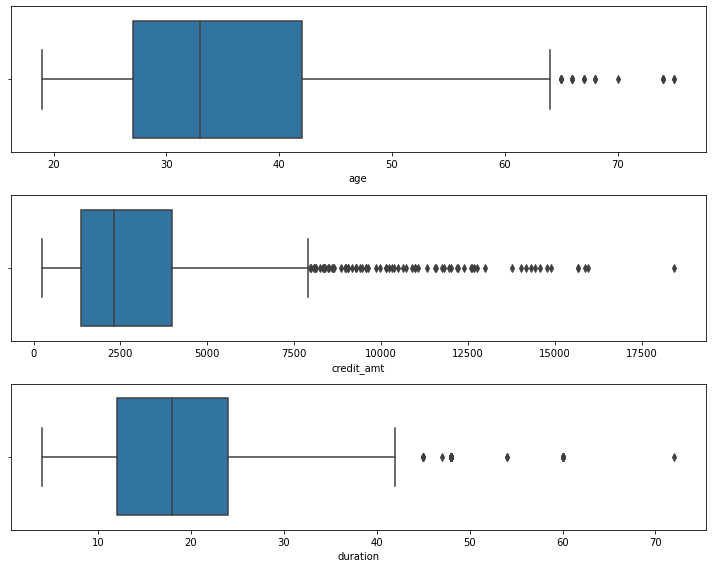

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,8))
sns.boxplot(num_data["age"], ax=ax1)
sns.boxplot(num_data["credit_amt"], ax=ax2)
sns.boxplot(num_data["duration"], ax=ax3)
plt.tight_layout()

C:\Users\shani\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\shani\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\shani\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


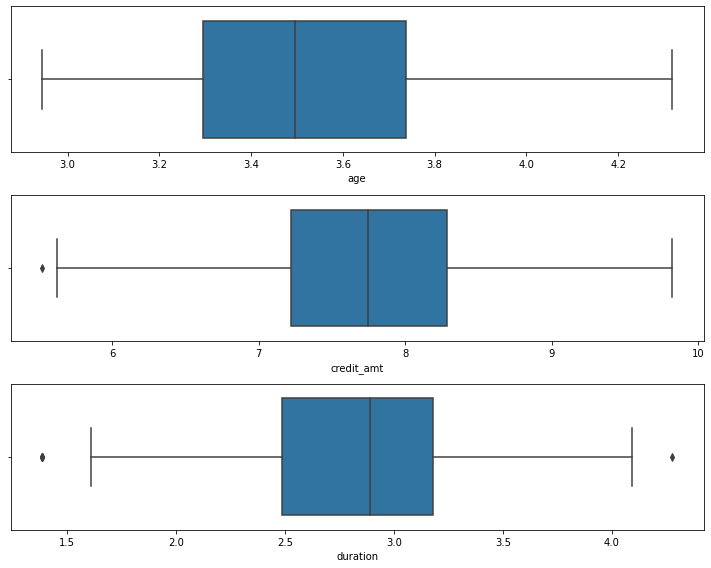

In [14]:
num_log = np.log(num_data[['age', 'credit_amt','duration']])

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,8))
sns.boxplot(num_log["age"], ax=ax1)
sns.boxplot(num_log["credit_amt"], ax=ax2)
sns.boxplot(num_log["duration"], ax=ax3)
plt.tight_layout()

#### Charts

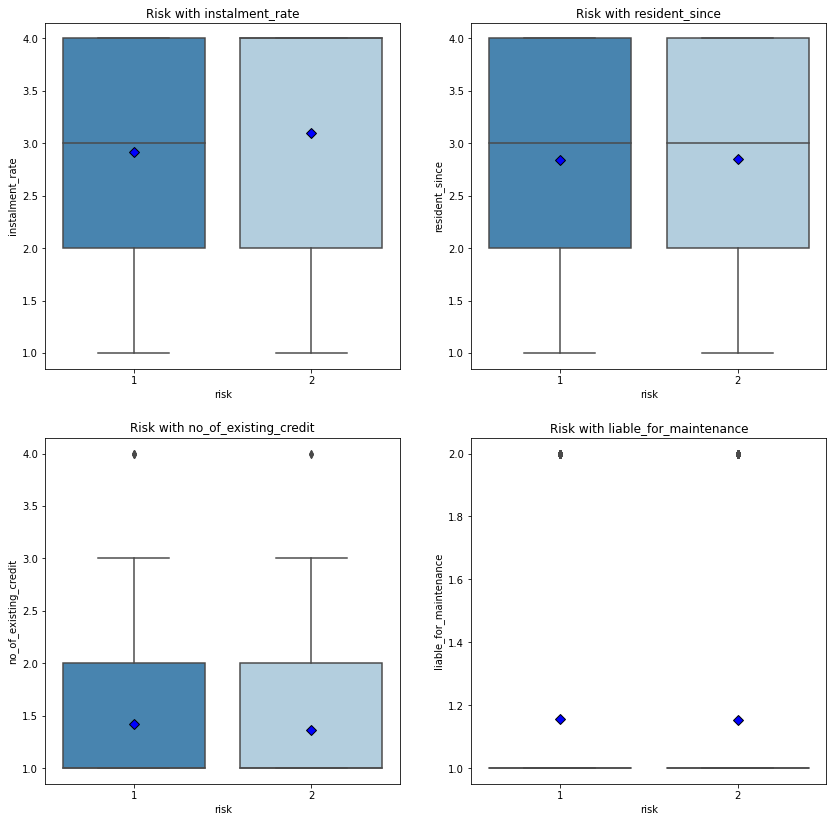

In [15]:
figure, axes = plt.subplots(2, 2, figsize=(14,14))  
k=[(0,0),(0,1),(1,0),(1,1)]  #Setting up indices to access axes
cols=['instalment_rate','resident_since','no_of_existing_credit','liable_for_maintenance']   #different fields to plot against Product
for i in (enumerate(cols)):        #assigns count to each of value in cols 
    sns.boxplot(
                x='risk', 
                y=i[1], 
                data=num_data, 
                ax=axes[k[i[0]][0]][k[i[0]][1]], 
                palette='Blues_r',
                showmeans=True,
                meanprops={"marker":"D",
                           "markerfacecolor":"blue", 
                           "markeredgecolor":"black",
                           "markersize":"7"
                          }
               ).set(title='Risk with ' + i[1])   #boxplot    

plt.show()

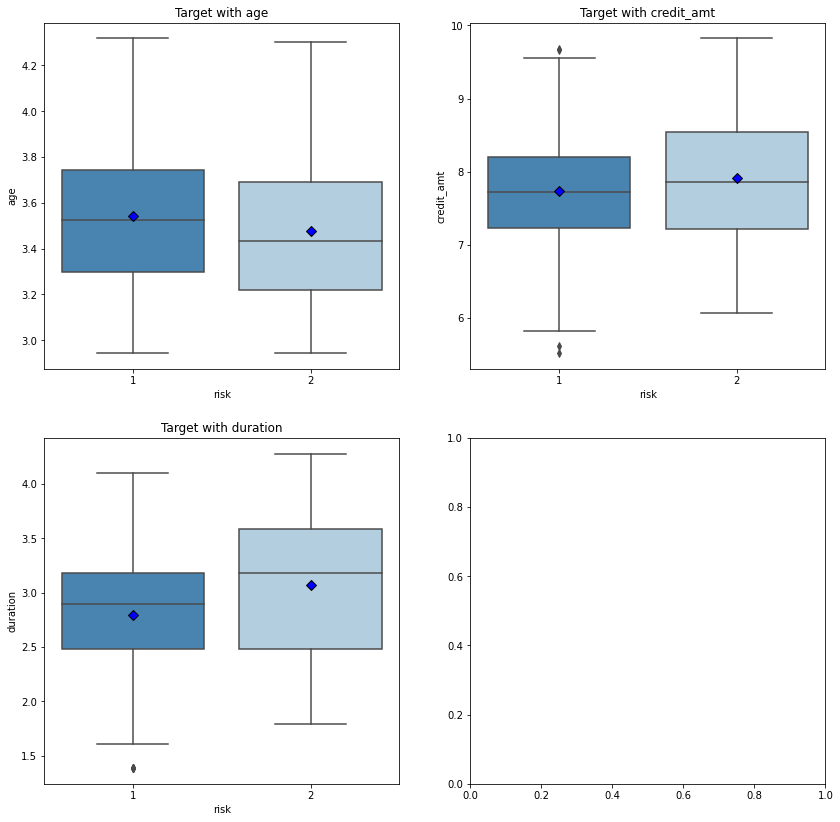

In [16]:
figure, axes = plt.subplots(2, 2, figsize=(14,14)) 
k=[(0,0),(0,1),(1,0),(1,1)]  #Setting up indices to access axes
cols=['age','credit_amt','duration']   #different fields to plot against Product
for i in (enumerate(cols)):        #assigns count to each of value in cols 
    sns.boxplot(
                x=num_data['risk'], 
                y=i[1], 
                data=num_log, 
                ax=axes[k[i[0]][0]][k[i[0]][1]], 
                palette='Blues_r',
                showmeans=True,
                meanprops={"marker":"D",
                           "markerfacecolor":"blue", 
                           "markeredgecolor":"black",
                           "markersize":"7"
                          }
               ).set(title='Target with ' + i[1])   #boxplot    

plt.show()

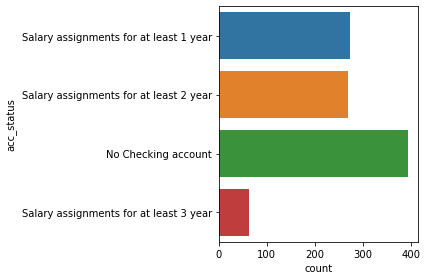

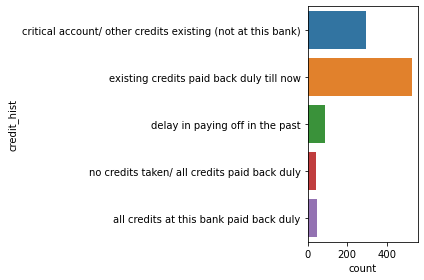

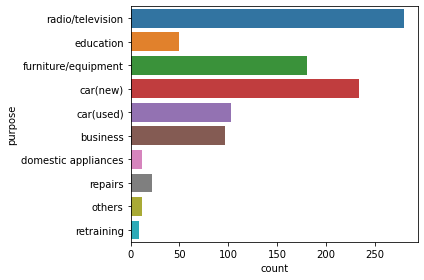

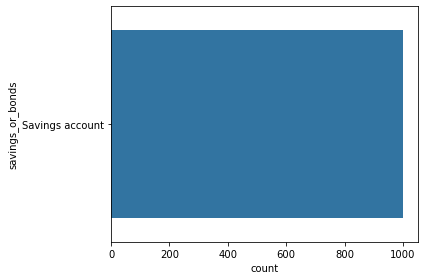

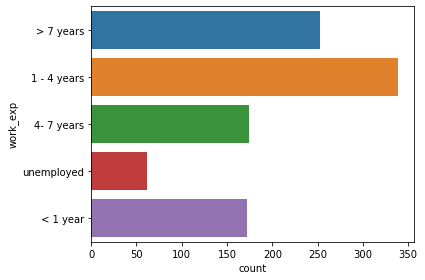

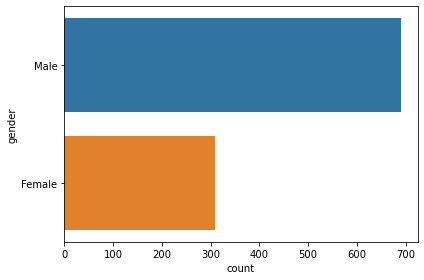

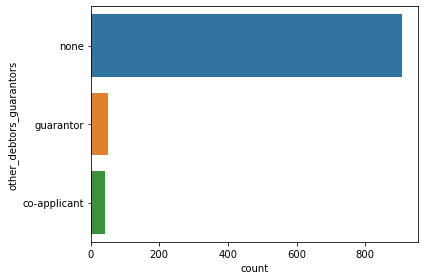

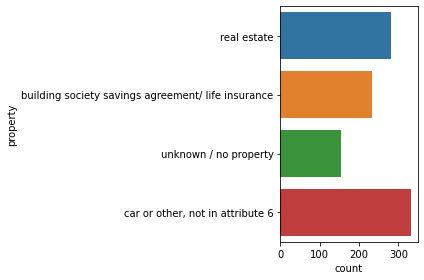

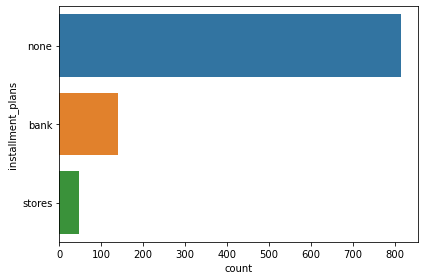

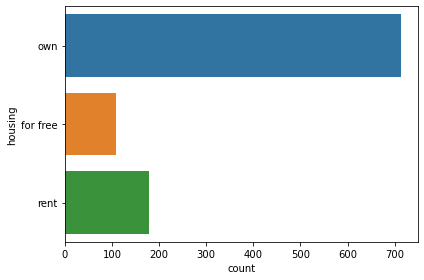

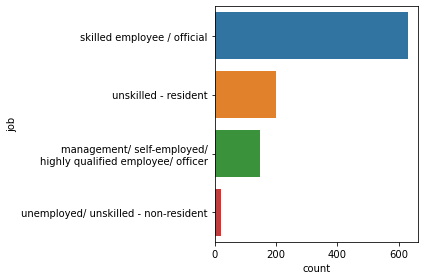

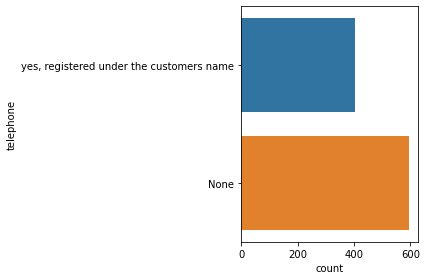

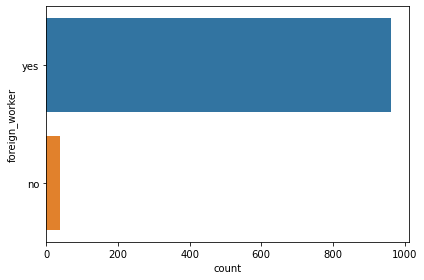

In [17]:
for col in cat_data.columns:
    sns.countplot(y =col, data = cat_data)
    plt.tight_layout()
    plt.show()

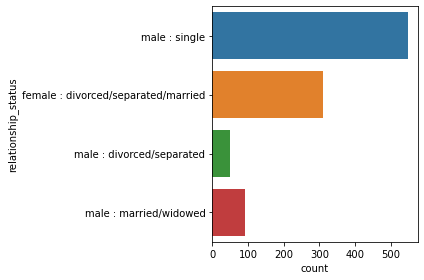

In [18]:
sns.countplot(y = bank_data['relationship_status'], data = bank_data)
plt.tight_layout()
plt.show()

#### Correlation Analysis

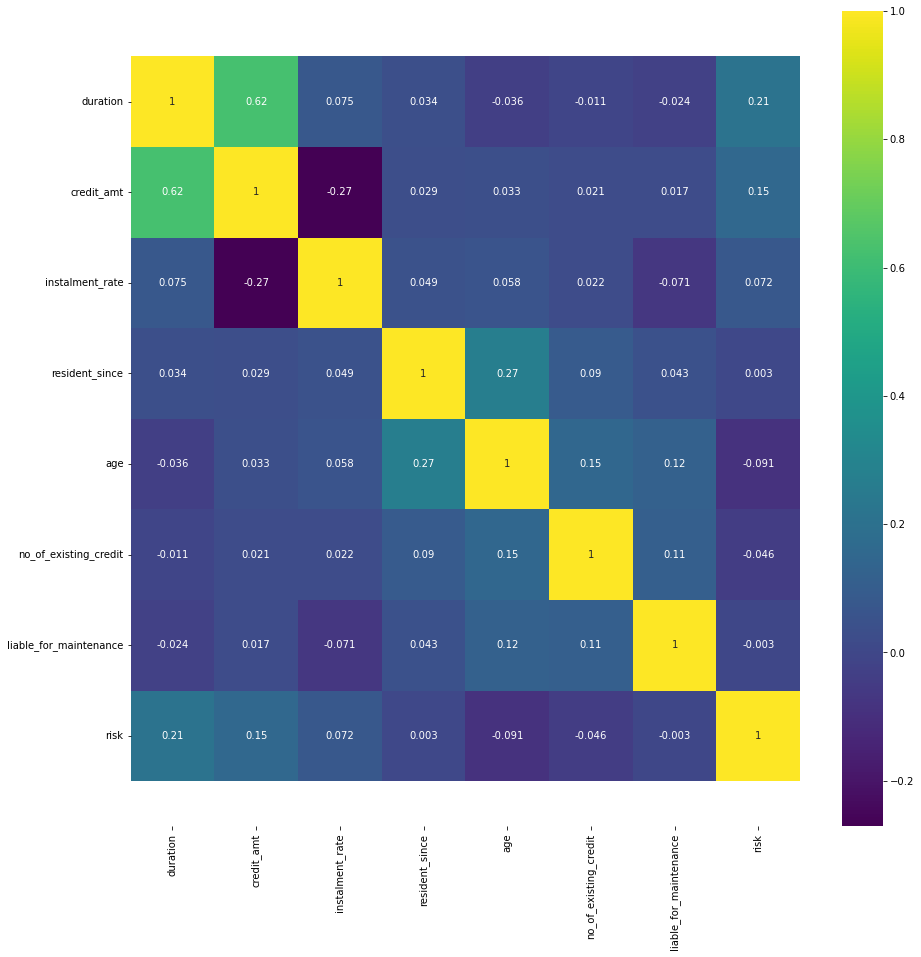

In [19]:
colormap = plt.cm.viridis
plt.figure(figsize=(15,15))
ax = sns.heatmap(num_data.astype(float).corr(), cmap=colormap, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

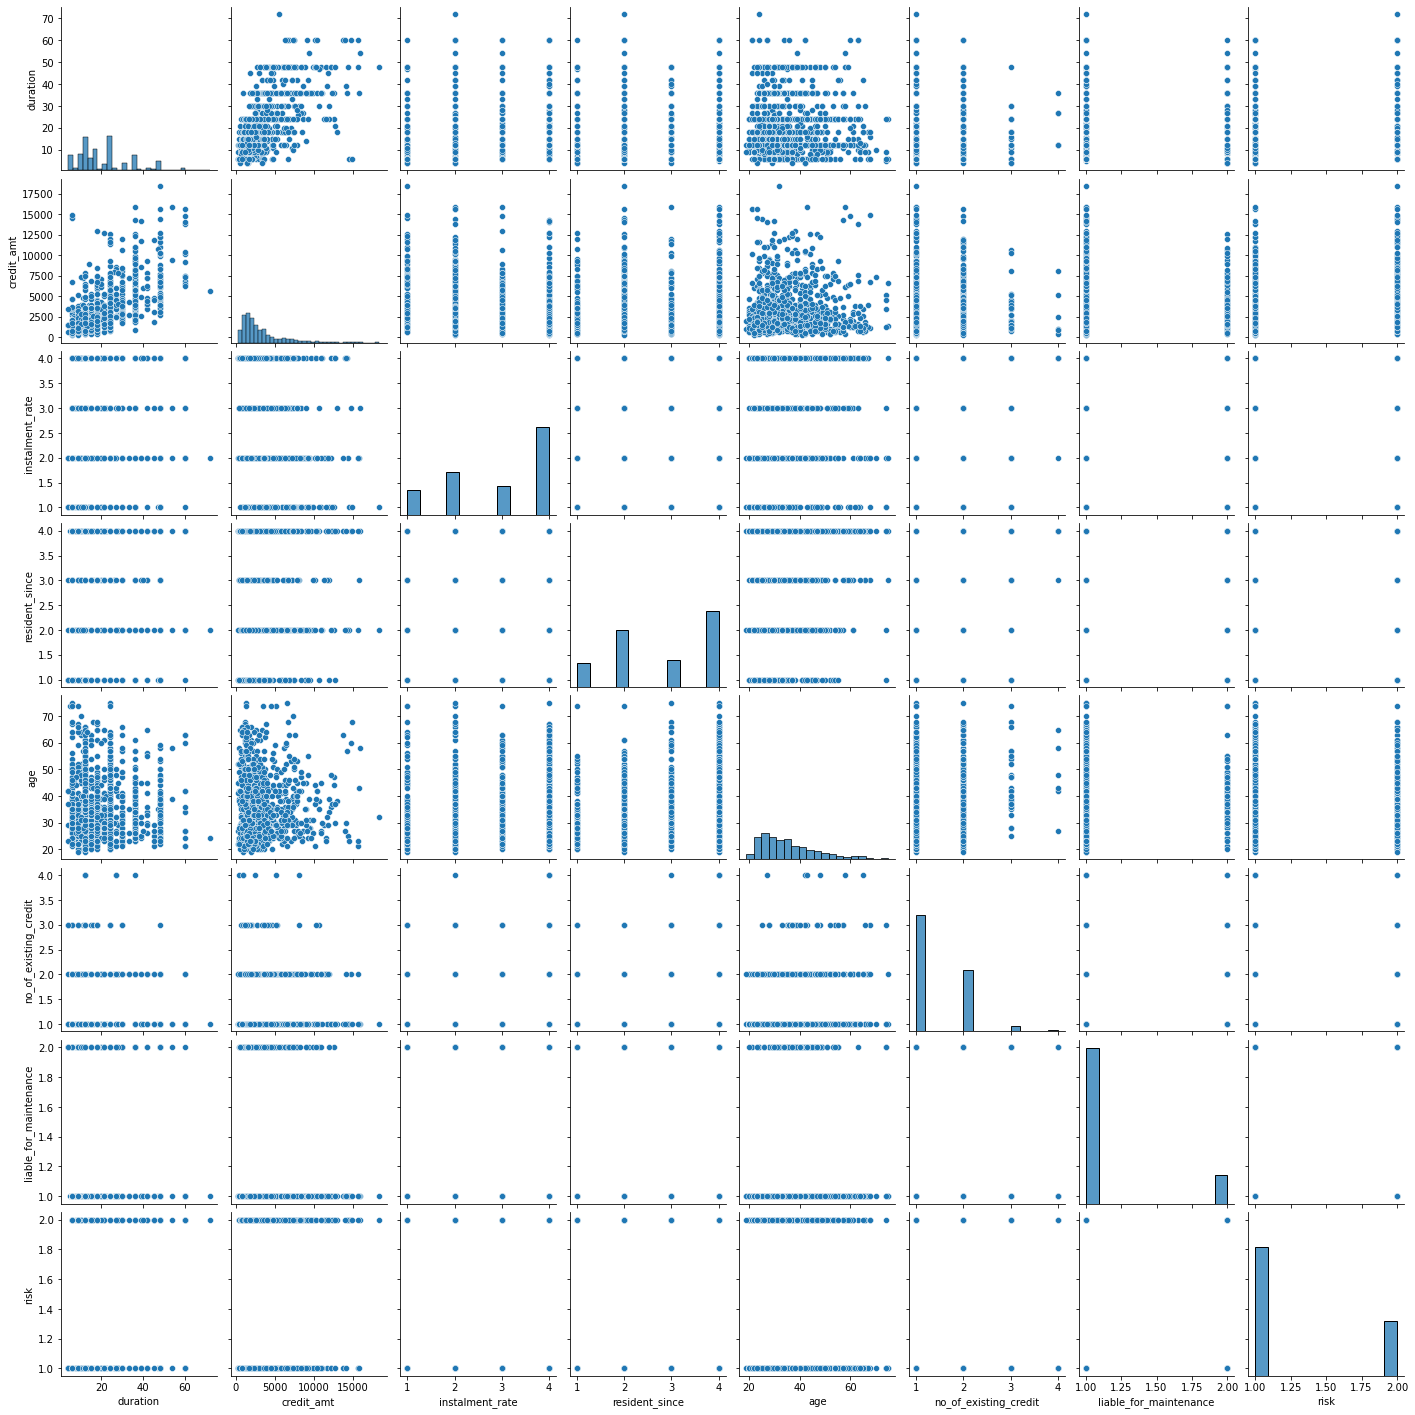

In [20]:
sns.pairplot(num_data)

In [21]:
cat_copy = cat_data.copy()
encoder = LabelEncoder()
for label in cat_copy:
    cat_copy[label] = encoder.fit_transform(cat_copy[label])
    
cat_copy.head()

,acc_status,credit_hist,purpose,savings_or_bonds,work_exp,gender,other_debtors_guarantors,property,installment_plans,housing,job,telephone,foreign_worker
0,1,1,7,0,3,1,2,2,1,1,1,1,1
1,2,3,7,0,1,0,2,2,1,1,1,0,1
2,0,1,4,0,2,1,2,2,1,1,3,0,1
3,1,3,5,0,2,1,1,0,1,0,1,0,1
4,1,2,1,0,1,1,2,3,1,0,1,0,1


In [22]:
cat_copy = cat_copy.drop(["savings_or_bonds"], axis=1)
cat_copy['risk'] = num_data['risk']

cat_copy.head()

,acc_status,credit_hist,purpose,work_exp,gender,other_debtors_guarantors,property,installment_plans,housing,job,telephone,foreign_worker,risk
0,1,1,7,3,1,2,2,1,1,1,1,1,1
1,2,3,7,1,0,2,2,1,1,1,0,1,2
2,0,1,4,2,1,2,2,1,1,3,0,1,1
3,1,3,5,2,1,1,0,1,0,1,0,1,1
4,1,2,1,1,1,2,3,1,0,1,0,1,2


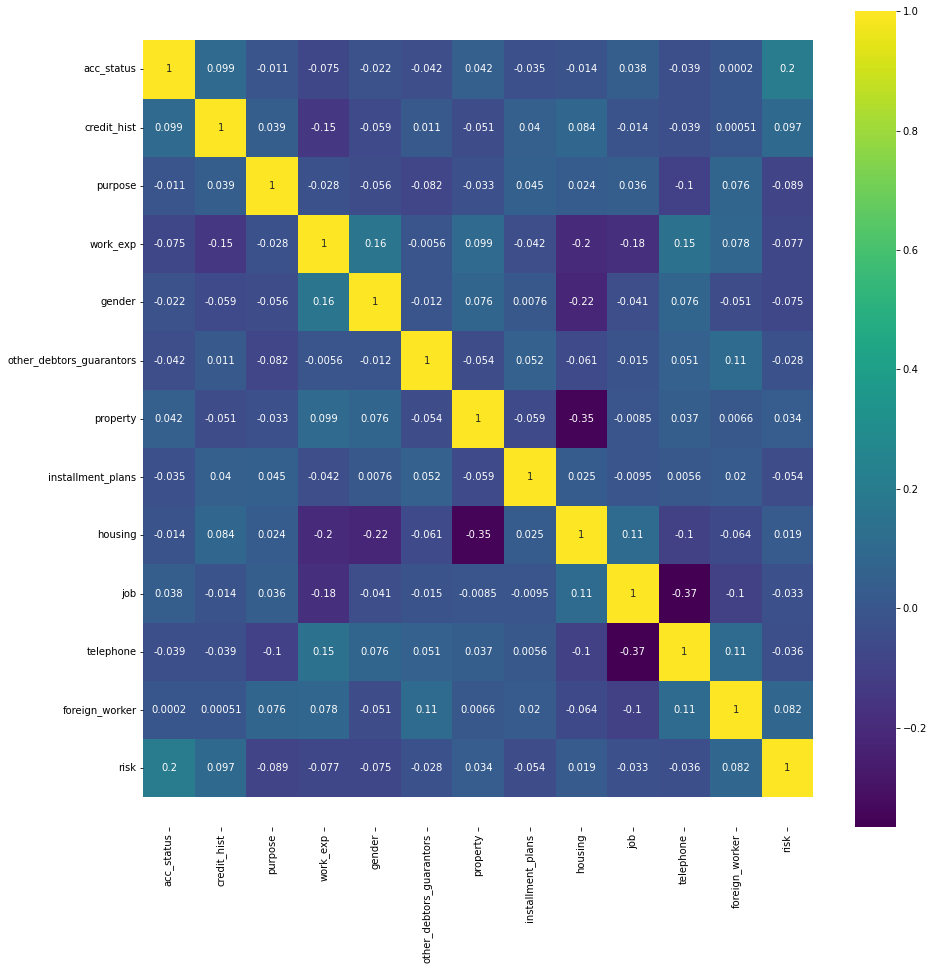

In [23]:
colormap = plt.cm.viridis
plt.figure(figsize=(15,15))
ax = sns.heatmap(cat_copy.astype(float).corr(), cmap=colormap, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

### 1.2 K-Means Clustering

In [24]:
df_cluster = pd.DataFrame()
df_cluster['age'] = num_data['age']
df_cluster['credit_amt'] = num_data['credit_amt']
df_cluster['duration'] = num_data['duration']

In [25]:
#scale
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(num_log)


C:\Users\shani\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


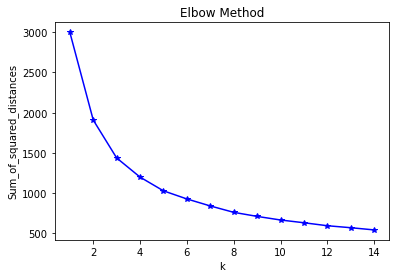

In [26]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(cluster_scaled)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'b-*')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method')
plt.show()

The optimal cluster would be 3

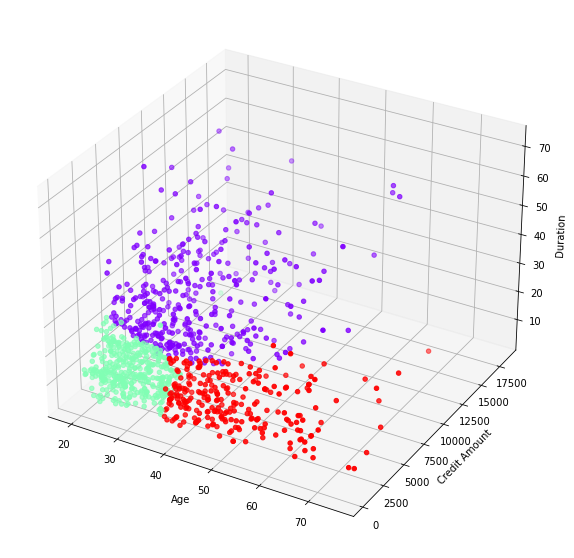

In [27]:
model = KMeans(n_clusters=3)
model.fit(cluster_scaled)
kmeans_labels = model.labels_

fig = plt.figure(num=None, figsize=(15, 10))
ax = plt.axes(projection="3d")

ax.scatter3D(df_cluster['age'],df_cluster['credit_amt'],df_cluster['duration'],c=kmeans_labels, cmap='rainbow')

xLabel = ax.set_xlabel('Age', linespacing=3.2)
yLabel = ax.set_ylabel('Credit Amount', linespacing=3.1)
zLabel = ax.set_zlabel('Duration', linespacing=3.4)

In [28]:
X = cluster_scaled
y = num_data["risk"].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=1)

In [29]:
num_data['risk'].value_counts()

1    700
2    300
Name: risk, dtype: int64

In [30]:
y_pred = model.predict(X_test)

print("Accuracy: ", accuracy_score(y_test,y_pred))
print("\n")
print(classification_report(y_test, y_pred))

Accuracy:  0.29


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.71      0.34      0.46       141
           2       0.19      0.17      0.18        59

    accuracy                           0.29       200
   macro avg       0.30      0.17      0.21       200
weighted avg       0.55      0.29      0.38       200



C:\Users\shani\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shani\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shani\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
model.inertia_

1437.6974164026612

In [32]:
silhouette_score(cluster_scaled, model.labels_)

0.30318933408774545

In [33]:
df_clustered_kmeans = df_cluster.assign(Cluster=kmeans_labels)
grouped_kmeans = df_clustered_kmeans.groupby(['Cluster']).mean().round(1)
grouped_kmeans

,age,credit_amt,duration
Cluster,,,
0,34.0,5665.4,32.2
1,27.8,1732.2,14.2
2,48.7,1979.7,13.9


age


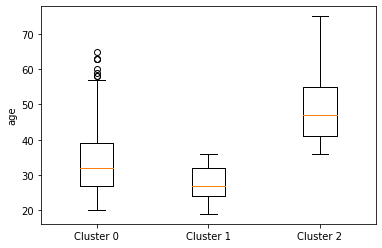

credit_amt


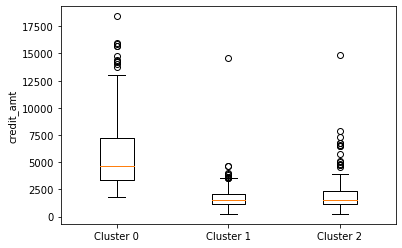

duration


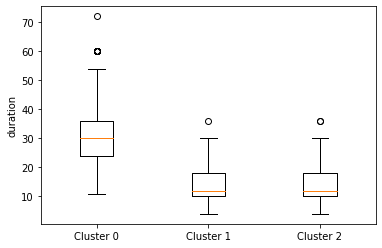

Cluster


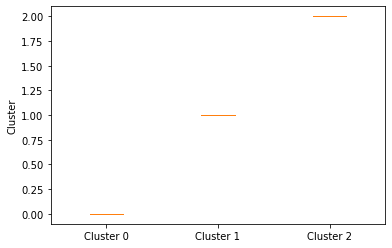

In [34]:
i=0
for col in df_clustered_kmeans: 
    print(col) 
    plt.cla()
    plt.boxplot([df_clustered_kmeans.iloc[:,i][df_clustered_kmeans.Cluster==0].tolist(),
                 df_clustered_kmeans.iloc[:,i][df_clustered_kmeans.Cluster==1].tolist(),
                df_clustered_kmeans.iloc[:,i][df_clustered_kmeans.Cluster==2].tolist()],
                 labels=('Cluster 0','Cluster 1', 'Cluster 2'))
    plt.ylabel(col)
    plt.show()
    i=i+1

#### Cluster 0 evaluation

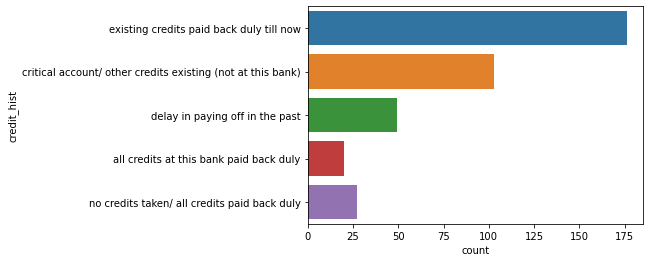

In [45]:
df_clustered_kmeans['credit_hist'] = cat_data['credit_hist']

sns.countplot(y ='credit_hist', data = df_clustered_kmeans[df_clustered_kmeans['Cluster']==0])
plt.show()

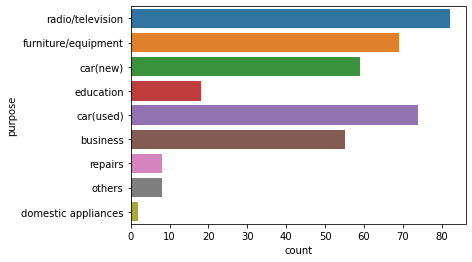

In [44]:
df_clustered_kmeans['purpose'] = bank_data['purpose']

sns.countplot(y ='purpose', data = df_clustered_kmeans[df_clustered_kmeans['Cluster']==0])
plt.show()

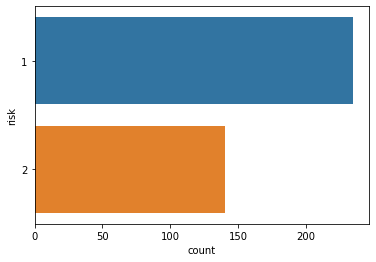

In [38]:
df_clustered_kmeans['risk'] = num_data['risk']

sns.countplot(y ='risk', data = df_clustered_kmeans[df_clustered_kmeans['Cluster']==0])
plt.show()

#### Cluster 1 evaluation

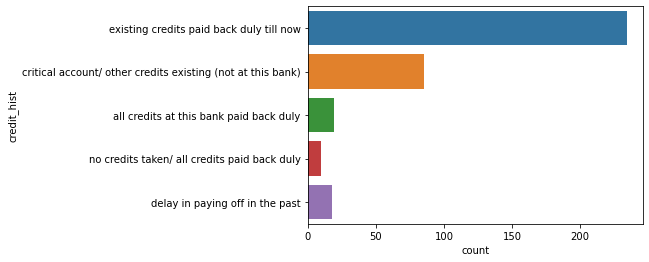

In [48]:
sns.countplot(y ='credit_hist', data = df_clustered_kmeans[df_clustered_kmeans['Cluster']==1])
plt.show()

In [ ]:
sns.countplot(y ='purpose', data = df_clustered_kmeans[df_clustered_kmeans['Cluster']==1])
plt.show()

In [ ]:
sns.countplot(y ='risk', data = df_clustered_kmeans[df_clustered_kmeans['Cluster']==1])
plt.show()

#### Cluster 2 evaluation

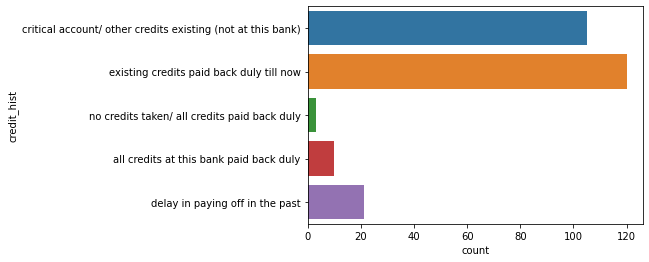

In [49]:
sns.countplot(y ='credit_hist', data = df_clustered_kmeans[df_clustered_kmeans['Cluster']==2])
plt.show()

In [ ]:
sns.countplot(y ='purpose', data = df_clustered_kmeans[df_clustered_kmeans['Cluster']==2])
plt.show()

In [ ]:
sns.countplot(y ='risk', data = df_clustered_kmeans[df_clustered_kmeans['Cluster']==2])
plt.show()

#### Improve model (not used)

In [ ]:
sil = []
k_range = range(2,11)

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in k_range:
    kmeans = KMeans(n_clusters = k).fit(cluster_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(cluster_scaled, labels, metric = 'euclidean'))
    
sil

In [ ]:
plt.bar(k_range, sil) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('Silouette Score', fontsize = 20)
plt.axis([1, 11, 0.1, 0.6])

plt.show()

In [ ]:
model = KMeans(n_clusters=2)
model.fit(cluster_scaled)
kmeans_labels = model.labels_

fig = plt.figure(num=None, figsize=(15, 10))
ax = plt.axes(projection="3d")

ax.scatter3D(num_data['age'],num_data['credit_amt'],num_data['duration'],c=kmeans_labels, cmap='rainbow')

xLabel = ax.set_xlabel('Age', linespacing=3.2)
yLabel = ax.set_ylabel('Credit Amount', linespacing=3.1)
zLabel = ax.set_zlabel('Duration', linespacing=3.4)

In [ ]:
model.inertia_

In [ ]:
silhouette_score(cluster_scaled, model.labels_)

In [ ]:
df_clustered_kmeans = df_cluster.assign(Cluster=kmeans_labels)
grouped_kmeans = df_clustered_kmeans.groupby(['Cluster']).mean().round(1)
grouped_kmeans

In [ ]:

i=0
for col in df_clustered_kmeans: 
    print(col) 
    plt.cla()
    plt.boxplot([df_clustered_kmeans.iloc[:,i][df_clustered_kmeans.Cluster==0].tolist(),
                 df_clustered_kmeans.iloc[:,i][df_clustered_kmeans.Cluster==1].tolist()],
                 labels=('Cluster 0','Cluster 1'))
    plt.ylabel(col)
    plt.show()
    i=i+1

### 1.3 Hierarchical Clustering

#### Ward linkage

In [ ]:
plt.figure(figsize=(20,10))
dendrogram = sch.dendrogram(sch.linkage(cluster_scaled, method='ward'))

In [ ]:
model = AgglomerativeClustering(n_clusters=4)
model.fit(cluster_scaled)
hc_labels = model.labels_

fig = plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")

ax.scatter3D(df_cluster['age'],df_cluster['credit_amt'],df_cluster['duration'],c=hc_labels, cmap='rainbow')

xLabel = ax.set_xlabel('Age', linespacing=3.2)
yLabel = ax.set_ylabel('Credit Amount', linespacing=3.1)
zLabel = ax.set_zlabel('Duration', linespacing=3.4)


In [ ]:
df_clustered_hc = df_cluster.assign(Cluster=hc_labels)
grouped_hc = df_clustered_hc.groupby(['Cluster']).mean().round(1)
grouped_hc

In [ ]:
silhouette_score(cluster_scaled, model.labels_)

##### Improve model

In [ ]:
k_range = range(2,11)
silhouette_scores =[]

for i in k_range:
    ac_i = AgglomerativeClustering(n_clusters = i,linkage='ward')
    silhouette_scores.append(silhouette_score(cluster_scaled, ac_i.fit_predict(cluster_scaled)))

silhouette_scores

In [ ]:
plt.bar(k_range, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('Silouette Score', fontsize = 20)
plt.axis([1, 11, 0.1, 0.6])
plt.show()

From above, we can see that 2 clusters have the highest silhouette score

In [ ]:
model = AgglomerativeClustering(n_clusters=2)
model.fit(cluster_scaled)
hc_labels = model.labels_

fig = plt.figure(num=None, figsize=(10, 10))
ax = plt.axes(projection="3d")

ax.scatter3D(df_cluster['age'],df_cluster['credit_amt'],df_cluster['duration'],c=hc_labels, cmap='rainbow')

xLabel = ax.set_xlabel('Age', linespacing=3.2)
yLabel = ax.set_ylabel('Credit Amount', linespacing=3.1)
zLabel = ax.set_zlabel('Duration', linespacing=3.4)

In [ ]:
df_clustered_hc = df_cluster.assign(Cluster=hc_labels)
grouped_hc = df_clustered_hc.groupby(['Cluster']).mean().round(1)
grouped_hc

In [ ]:
i=0
for col in df_clustered_hc: 
    print(col) 
    plt.cla()
    plt.boxplot([df_clustered_hc.iloc[:,i][df_clustered_hc.Cluster==0].tolist(),
                 df_clustered_hc.iloc[:,i][df_clustered_hc.Cluster==1].tolist()],
                 labels=('Cluster 0','Cluster 1'))
    plt.ylabel(col)
    plt.show()
    i=i+1

Cluster 0 : Lower credit amount, middle age, short duration 

Cluster 1 : Higher credit amount, older , long duration customers


In [ ]:
silhouette_score(cluster_scaled, model.labels_)

#### Average linkage

In [ ]:
plt.figure(figsize=(30,10))
dendrogram = sch.dendrogram(sch.linkage(cluster_scaled, method='average'))

In [ ]:
k_range = range(2,11)
silhouette_scores =[]

for i in k_range:
    ac_i = AgglomerativeClustering(n_clusters = i,linkage='average')
    silhouette_scores.append(silhouette_score(cluster_scaled, ac_i.fit_predict(cluster_scaled)))
    
silhouette_scores

In [ ]:
plt.bar(k_range, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('Silouette Score', fontsize = 20)
plt.axis([1, 11, 0.1, 0.6])
plt.show() 

From above, 3 is the optimal cluster

In [ ]:
model = AgglomerativeClustering(n_clusters=3)
model.fit(cluster_scaled)
hc_labels = model.labels_

fig = plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")

ax.scatter3D(df_cluster['age'],df_cluster['credit_amt'],df_cluster['duration'],c=hc_labels, cmap='rainbow')

xLabel = ax.set_xlabel('Age', linespacing=3.2)
yLabel = ax.set_ylabel('Credit Amount', linespacing=3.1)
zLabel = ax.set_zlabel('Duration', linespacing=3.4)

In [ ]:
silhouette_score(cluster_scaled, model.labels_)

Ward vs Average linkage:

I will use the ward linkage method as it has a higher sihouette score of 0.27 compared to 0.24 for average method